# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
snowball = SnowballStemmer(language='english')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier as XGB
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
import transformers
from transformers import DistilBertTokenizer, TFDistilBertModel
from transformers import TFDistilBertForSequenceClassification, DistilBertConfig
from numba import cuda
from nltk.tokenize import word_tokenize
import tensorflow_text as tftext
import tensorflow_hub as tfhub
import keras_nlp
import keras
from keras import layers

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using TensorFlow backend


# Loading the training CSV file

In [2]:
train_csv_loc = "/kaggle/input/llm-detect-ai-generated-text/train_essays.csv"
train_csv = pd.read_csv(train_csv_loc)
train_csv

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


# Loading the prompts CSV files

In [3]:
prompts_csv = "/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv"
pd.read_csv(prompts_csv)

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


# Analyzing test dataset

generated
0    1375
1       3
Name: text, dtype: int64


([<matplotlib.patches.Wedge at 0x788d7bbaa380>,
 [Text(-1.0999742722741532, 0.0075233194101512945, 'generated by students'),
  Text(1.099974272477764, -0.007523289640464896, 'generated by LLM')],
 [Text(-0.5999859666949926, 0.004103628769173433, '99.78%'),
  Text(0.599985966806053, -0.00410361253116267, '0.22%')])

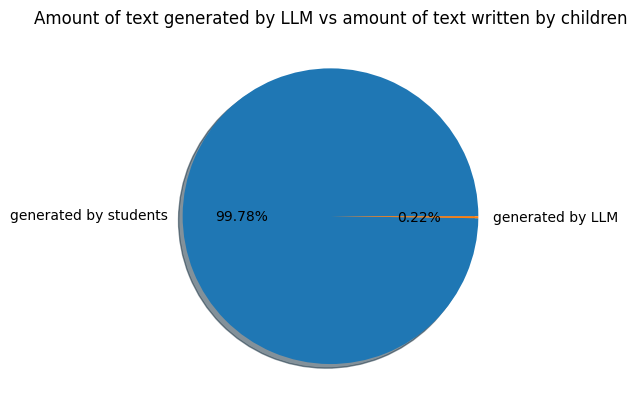

In [4]:
llm_gen_perc = train_csv.groupby('generated').count()['text']
print(llm_gen_perc)
plt.title("Amount of text generated by LLM vs amount of text written by children")
plt.pie(llm_gen_perc,labels=['generated by students','generated by LLM'],autopct = '%0.2f%%',shadow=True)

Only 3 out of 1378 entries are generated by LLM accounting for mere 0.2%. This is an extreme class imbalance.

prompt_id
0    708
1    670
Name: generated, dtype: int64


([<matplotlib.patches.Wedge at 0x788d79a4ee30>,
 [Text(-0.04763336781987195, 1.0989681807359741, 'Car-free cities'),
  Text(0.047633367819872305, -1.0989681807359741, 'Does the electoral college work?')],
 [Text(-0.025981836992657426, 0.5994371894923495, '51.38%'),
  Text(0.025981836992657617, -0.5994371894923495, '48.62%')])

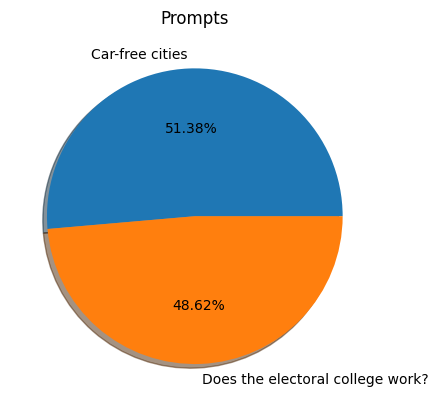

In [5]:
prompt_perc = train_csv.groupby('prompt_id').count()['generated']
print(prompt_perc)
plt.title("Prompts")
plt.pie(prompt_perc,labels=["Car-free cities","Does the electoral college work?"],autopct="%0.2f%%",shadow=True)

# Adding new data to prevent class imbalance

In [6]:
dataset_1_loc ='/kaggle/input/llm-mistral-7b-instruct-texts/Mistral7B_CME_v6.csv'
aug_data1 = pd.read_csv(dataset_1_loc)
aug_data1 = aug_data1[aug_data1["prompt_id"]==2]
aug_data1["prompt_id"]=aug_data1['prompt_id']-2
aug_data1

,prompt_id,text,prompt_name,generated
3500,0,Car-free cities are becoming increasingly pop...,Car-free cities,1
3501,0,Car-free cities are becoming increasingly pop...,Car-free cities,1
3502,0,Car-free cities are becoming increasingly pop...,Car-free cities,1
3503,0,Car-free cities have become increasingly popu...,Car-free cities,1
3504,0,Car-free cities are a growing concept in toda...,Car-free cities,1
...,...,...,...,...
4195,0,The concept of car-free cities is becoming in...,Car-free cities,1
4196,0,Car-free cities: a vision for a healthier and...,Car-free cities,1
4197,0,The concept of car-free cities has gained pop...,Car-free cities,1
4198,0,Car-free cities are cities where cars are not...,Car-free cities,1


In [7]:
dataset_2_loc = '/kaggle/input/llm-mistral-7b-instruct-texts/Mistral7B_CME_v7.csv'
aug_data2 = pd.read_csv(dataset_2_loc)
aug_data2 = aug_data2[aug_data2["prompt_id"]==12]
aug_data2["prompt_id"]=aug_data2['prompt_id']-11
aug_data2

,prompt_id,text,prompt_name,generated
4200,1,The electoral college is a system that is use...,Does the electoral college work?,1
4201,1,The electoral college system that is used to ...,Does the electoral college work?,1
4202,1,The electoral college is a system used in the...,Does the electoral college work?,1
4203,1,The electoral college is a system in which ci...,Does the electoral college work?,1
4204,1,The Electoral College is a system used in the...,Does the electoral college work?,1
...,...,...,...,...
4895,1,The electoral college is one of the most disc...,Does the electoral college work?,1
4896,1,"Dear Sen. [Name],\n\nI am writing to express ...",Does the electoral college work?,1
4897,1,The electoral college is a system that is use...,Does the electoral college work?,1
4898,1,A strong electoral system is vital to the fun...,Does the electoral college work?,1


In [8]:
aug_data_mistral = pd.concat([aug_data1,aug_data2],axis=0)
aug_data_mistral

,prompt_id,text,prompt_name,generated
3500,0,Car-free cities are becoming increasingly pop...,Car-free cities,1
3501,0,Car-free cities are becoming increasingly pop...,Car-free cities,1
3502,0,Car-free cities are becoming increasingly pop...,Car-free cities,1
3503,0,Car-free cities have become increasingly popu...,Car-free cities,1
3504,0,Car-free cities are a growing concept in toda...,Car-free cities,1
...,...,...,...,...
4895,1,The electoral college is one of the most disc...,Does the electoral college work?,1
4896,1,"Dear Sen. [Name],\n\nI am writing to express ...",Does the electoral college work?,1
4897,1,The electoral college is a system that is use...,Does the electoral college work?,1
4898,1,A strong electoral system is vital to the fun...,Does the electoral college work?,1


In [9]:
google_palm = pd.read_csv('/kaggle/input/llm-generated-essay-using-palm-from-google-gen-ai/LLM_generated_essay_PaLM.csv').drop(columns=['id'])
google_palm = google_palm.drop(columns=['prompt_id'])
google_palm

,text,generated
0,## The Advantages of Limiting Car Usage\n\nIn ...,1.0
1,"The United States is a car-dependent nation, w...",1.0
2,"In recent years, there has been a growing move...",1.0
3,"In recent years, there has been a growing move...",1.0
4,"In the past few decades, the United States has...",1.0
...,...,...
1379,"Dear Senator,\n\nI am writing to you today to ...",1.0
1380,"Dear Senator,\n\nI am writing to you today to ...",1.0
1381,"Dear Senator,\n\nI am writing to you today to ...",1.0
1382,"Dear Senator,\n\nI am writing to you today to ...",1.0


In [10]:
big_set =pd.read_csv('/kaggle/input/augmented-data-for-llm-detect-ai-generated-text/final_train.csv')
big_set_0_4000 = big_set[big_set['label']==0].iloc[0:4000,:] #first 2000 rows of human written texts
big_set_1_2600 = big_set[big_set['label']==1].iloc[0:2600,:] #first 600 rows of AI written texts
big_set_0_4000

,text,label
0,We should keep the Electoral College for a num...,0
2,Limiting car usage can actually be effective b...,0
4,"Dear Principal,\n\nAfter school or during scho...",0
5,"Many people think that aliens are real, but th...",0
8,I think if a student has a C average he or she...,0
...,...,...
6358,""" All of our development since World War 2 has...",0
6362,Some people do extracurricular activities and ...,0
6363,Exploring Venus would be a pretty amazing expe...,0
6366,You should participate in the Seagoing cowboys...,0


In [11]:
big_set_6600 = pd.concat([big_set_0_4000,big_set_1_2600],axis=0)
big_set_6600.rename(columns={'label':'generated'},inplace=True)
big_set_6600

,text,generated
0,We should keep the Electoral College for a num...,0
2,Limiting car usage can actually be effective b...,0
4,"Dear Principal,\n\nAfter school or during scho...",0
5,"Many people think that aliens are real, but th...",0
8,I think if a student has a C average he or she...,0
...,...,...
7005,The debate over whether children should be tau...,1
7013,I strongly believe that working in groups is ...,1
7014,The advantages of limiting car usage are evid...,1
7015,The use of E-dictionaries is increasingly popu...,1


In [12]:
aug_data_mistral = aug_data_mistral.drop(columns= ['prompt_name','prompt_id'])
aug_data_mistral

,text,generated
3500,Car-free cities are becoming increasingly pop...,1
3501,Car-free cities are becoming increasingly pop...,1
3502,Car-free cities are becoming increasingly pop...,1
3503,Car-free cities have become increasingly popu...,1
3504,Car-free cities are a growing concept in toda...,1
...,...,...
4895,The electoral college is one of the most disc...,1
4896,"Dear Sen. [Name],\n\nI am writing to express ...",1
4897,The electoral college is a system that is use...,1
4898,A strong electoral system is vital to the fun...,1


Dropped prompt name column as it was unnecessary because prompt Id is already given.

In [13]:
train_csv= train_csv.drop(columns=['id','prompt_id'])
train_csv

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0
...,...,...
1373,There has been a fuss about the Elector Colleg...,0
1374,Limiting car usage has many advantages. Such a...,0
1375,There's a new trend that has been developing f...,0
1376,As we all know cars are a big part of our soci...,0


Dropped id column as it is not necessary for training and also to concatenate with new dataset

prompt_id dropped because prompt_id column wasn't there in the biggest dataset posing a problem in concatenating. 

# Final dataset to be used

In [14]:
final_data = pd.concat([train_csv,aug_data_mistral,big_set_6600,google_palm],axis=0)
final_data

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0
...,...,...
1379,"Dear Senator,\n\nI am writing to you today to ...",1.0
1380,"Dear Senator,\n\nI am writing to you today to ...",1.0
1381,"Dear Senator,\n\nI am writing to you today to ...",1.0
1382,"Dear Senator,\n\nI am writing to you today to ...",1.0


Final dataset is completed and ready to work on

In [15]:
final_data['text'].index = np.arange(0,final_data.shape[0])
final_data['text']

0        Cars. Cars have been around since they became ...
1        Transportation is a large necessity in most co...
2        "America's love affair with it's vehicles seem...
3        How often do you ride in a car? Do you drive a...
4        Cars are a wonderful thing. They are perhaps o...
                               ...                        
10757    Dear Senator,\n\nI am writing to you today to ...
10758    Dear Senator,\n\nI am writing to you today to ...
10759    Dear Senator,\n\nI am writing to you today to ...
10760    Dear Senator,\n\nI am writing to you today to ...
10761    Dear Senator,\n\nI am writing to you today to ...
Name: text, Length: 10762, dtype: object

In [16]:
final_data = final_data.drop_duplicates()
final_data

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0
...,...,...
1379,"Dear Senator,\n\nI am writing to you today to ...",1.0
1380,"Dear Senator,\n\nI am writing to you today to ...",1.0
1381,"Dear Senator,\n\nI am writing to you today to ...",1.0
1382,"Dear Senator,\n\nI am writing to you today to ...",1.0


([<matplotlib.patches.Wedge at 0x788d79928d90>,
 [Text(-0.014587613583003966, 1.0999032691695907, 'generated by AI'),
  Text(0.014587613583004318, -1.0999032691695907, 'not generated by AI')],
 [Text(-0.00795688013618398, 0.5999472377288676, '50.42%'),
  Text(0.007956880136184173, -0.5999472377288676, '49.58%')])

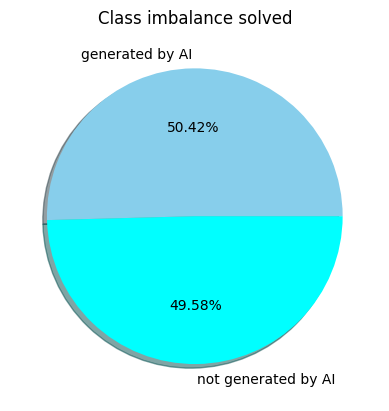

In [17]:
classes = final_data.groupby('generated').count()['text']
plt.title('Class imbalance solved')
plt.pie(classes, labels=['generated by AI','not generated by AI'],colors=['skyblue','cyan'],shadow=True,autopct='%0.2f%%')

In [18]:
def cleantext(data) :
    stemtext = []
    len_text = []
    para = data['text'].tolist()
    for paragraph in para:
        char = [char for char in paragraph if char not in string.punctuation]
        word = "".join(char).split(" ")
        words = [word.lower() for word in word if word not in stopwords.words('english')]
        stemwords = [SnowballStemmer('english').stem(word) for word in words]
        len_text.append(len(stemwords))
        stemtext.append(" ".join(stemwords))
    return stemtext , len_text

In [19]:
traintext = cleantext(final_data)[0]

In [20]:
print("Average length of essays after cleaning the dataset is " , np.mean(cleantext(final_data)[1]))

Average length of essays after cleaning the dataset is  224.77288930581614


# Splitting the dataset into train and test

In [21]:
x_train, x_test ,y_train , y_test = train_test_split(final_data.iloc[:,0:2], final_data['generated'],test_size=0.2)
x_train['labels'] = y_train
x_test['labels'] = y_test

In [22]:
x_train

,text,generated,labels
2716,Using technology that reads emotions in a stud...,0.0,0.0
3572,"Dear Principal Johnson, \n\nI am writing to ex...",1.0,1.0
3883,There is no doubt that young people today are ...,1.0,1.0
5209,"Millions of people around the world use cars, ...",0.0,0.0
1519,The Face on Mars may look like an alien artifa...,0.0,0.0
...,...,...,...
1480,"Twenty-five years ago, NASA's Viking 1 spotted...",0.0,0.0
3467,Dear Principal:\n\nI think it's a perfect idea...,0.0,0.0
4171,Being bored in the middle of class really suck...,0.0,0.0
3723,The idea of having car-free cities is becomin...,1.0,1.0


# Preprocessing and fitting dataset in BERT model

In [23]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = tfhub.KerasLayer(
    "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
encoder_inputs = preprocessor(text_input)
encoder = tfhub.KerasLayer(
    "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-10-h-512-a-8/versions/2",
    trainable=True)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      
sequence_output = outputs["sequence_output"] 

dense_1 = tf.keras.layers.Dense(128 , activation='relu')(pooled_output)
dropout = tf.keras.layers.Dropout(0.7 , name="dropout1")(pooled_output)
dense_2 = tf.keras.layers.Dense(64 , activation='relu')(dropout)
dropout1 = tf.keras.layers.Dropout(0.5 , name="dropout2")(dense_2)
dense_3 = tf.keras.layers.Dense(16,activation='relu')(dropout1)

dense_out = tf.keras.layers.Dense(1 , activation='sigmoid', name='output')(dropout1)


model = tf.keras.Model(inputs=text_input, outputs=dense_out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_mask': (None, 128)   0         ['input_1[0][0]']             
                             , 'input_word_ids': (None,                                           
                              128),                                                               
                              'input_type_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 0.00003),
              loss='binary_crossentropy',
              metrics=["accuracy"])
metric = 'val_accuracy'
checkpoint_filepath = 'checkpoint.hdf5'
callback_list = [tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, 
                                                    monitor=metric,
                                                    verbose=2,
                                                    save_best_only=True,
                                                    mode='max'), 
                 tf.keras.callbacks.EarlyStopping(monitor=metric,
                                                  patience=0,
                                                  restore_best_weights=True)
                ]
history = model.fit(x_train['text'], x_train['labels'] , batch_size=4,
                    epochs=5 , validation_data=(x_test['text'], x_test['labels']))
model.save("bertmodel")

Epoch 1/5
2132/2132 [==============================] - 213s 80ms/step - loss: 0.2217 - accuracy: 0.9224 - val_loss: 0.1514 - val_accuracy: 0.9629
Epoch 2/5
2132/2132 [==============================] - 153s 72ms/step - loss: 0.0735 - accuracy: 0.9797 - val_loss: 0.1203 - val_accuracy: 0.9681
Epoch 3/5
2132/2132 [==============================] - 152s 71ms/step - loss: 0.0534 - accuracy: 0.9831 - val_loss: 0.0420 - val_accuracy: 0.9869
Epoch 4/5
2132/2132 [==============================] - 151s 71ms/step - loss: 0.0393 - accuracy: 0.9894 - val_loss: 0.0757 - val_accuracy: 0.9648
Epoch 5/5
2132/2132 [==============================] - 151s 71ms/step - loss: 0.0355 - accuracy: 0.9902 - val_loss: 0.0704 - val_accuracy: 0.9808


In [25]:
final_test = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
final_test

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [26]:
test_text = cleantext(final_test)[0]

In [27]:
final_test['text'] = test_text

# Prediction

In [28]:
pred = model.predict(final_test['text'].values)
pred

1/1 [==============================] - 1s 846ms/step


array([[7.5371593e-01],
       [1.5798147e-05],
       [2.0182997e-05]], dtype=float32)

In [29]:
test_result = pred[:,0]
test_result

array([7.5371593e-01, 1.5798147e-05, 2.0182997e-05], dtype=float32)

In [30]:
final_submission = pd.DataFrame(final_test['id'])
final_submission['generated'] = test_result
final_submission

,id,generated
0,0000aaaa,0.753716
1,1111bbbb,0.000016
2,2222cccc,0.000020


In [31]:
final_submission.to_csv('submission.csv', index=False)